# Predicting Loan Cancellation #

## Summary
I built a parsimonious model by first reducing the total number of variables to a workable representative set, investigating the effect of each variable on the probability of loan cancellation, and discarding variables with limited predictivity. My final model achieves an AUC score of 0.649, with ROC curve shown below.

![My final ROC curve](./roc_final.jpg)

My final model uses six numerical variables: BorrowerRate, DolLoanAmountRequested, DolMonthlyDebt, DolMonthlyIncome, NumRealEstateTrades and PctBankcardUtil. I also use two categorical variables based on employment (StrEmploymentStatus and StrOccupation), and created four boolean variables based on other variables: BoolNonzeroPublicRecordsLast10Years, BoolOldLoanee, BoolPriorProsperLoanee and BoolYoungLoanee.


## Methodology

### Dimensional Reduction

To handle the large number of columns in the data (86 to start), my initial focus was dimensional reduction: Finding a smaller set of variables that still encompasses most of the original information. One way to do this would be Principal Component Analysis (PCA) followed by rotation of eigenvectors, but since I was dealing with an unfamiliar data set, I preferred to use a different method to allow me to pare down data more deliberately. Instead, I used Pearson's r to find variables that were highly correlated, which I then turned into a graph with networkx to find connected families. After doing this, I chose one representive variable from each family and dropped the rest. 

My first application of this graph technique with r = .55 found twelve families and reduced the number of variables from 80 to 56. I chose an r such that the max family size would be no larger than 10. I then reapplied the same method with a lower cutoff of r = .45. This method proved to be imperfect - in the original run-through, I ended up discarding NumPriorProsperLoans, which I later realized to be highly important.

### Logistic Regression with Individual Variables

I then performed a logistic regression with each individual variable to see whether a significant relation exists, and then I started to build my final logistic model one variable at a time. In the case of clearly related families of variables, such as the combination of DolMonthlyDebt-DolMonthlyIncome-FracDebtToIncomeRatio, I investigated the set of variables as a group to see what combination of variables provided better predictivity (in this case, DolMonthlyDebt and DolMonthlyIncome performed best). Plugging in each variable at a time proved painstaking, but given my unfamiliarity with loan data I didn't feel comfortable with making assumptions about which variables might be significant.

### Creating New Variables

In some cases, a logistic regression revealed nonlinear behavior. For instance, when analyzing NumPriorProsperLoans, I found a significant decline in the probability of cancellation if the potential loanee had taken out a Prosper loan before, but no further effect if users had taken out multiple loans. Therefore, I created a new boolean variable, BoolPriorProsperLoanee, to better capture this behavior. I also wound up doing the same thing with NumPublicRecordsLast10Years and DateFirstCredit, converting them into BoolNonzeroPublicRecordsLast10Years and the pair BoolOldLoanee and BoldYoungLoanee respectively.


## Key Findings

* One of the best predictors of loan cancellation is familiarity with the Prosper platform. Users who have taken out a Prosper loan before have only a 13% chance of cancellation, versus 35% if they have not. However, only 6.5% of potential loans are by previous loanees, so we need further differentiating information.

* Potential loanees who list their employment status as "Other" are much more likely to cancel than those listing their employment status as Employed, Full-time and Self-Employed - 49% versus 32%. However, only 7.8% of potential loanees list their employment status as Other. Conversely, and perhaps unexpectedly, loanees who list their employment status as Self-Employed have only a 20% chance of cancelling (6.2% of population).

* The larger the potential loan, the more likely the loan will eventually be cancelled.

* Potential loanees with higher monthly income are much more likely to cancel, whereas higher monthly debt leads to lower probability of cancellation.

* A higher percentage of bankcard use correlates with lower probability of cancellation.

* There are 67 different occupations listed, and I was therefore reluctant to include StrOccupation in my model without better insight into why individuals from certain professions would be more likely to cancel. However, including StrOccupation greatly increases predictive strength, and the sample sizes of different professions are large enough (several hundred) that the change in cancellation probability was very likely a real effect, so I wound up including StrOccupation as a categorical variable.

### Other Findings

* One might expect the interest rate of the loan to strongly influence cancellations, but in fact higher interest rates only slightly increase cancellation probability, subordinate to other factors (but still significant enough to merit inclusion in my final model).

* Young and old loanees (either <4000 days of credit history or >12000) are both more likely to cancel, perhaps for different reasons.

* Having a public record of a completed mortgage within the past 10 years and having a nonzero number of real estate trades on record both correspond with lower probability of cancellation.

In [91]:
%matplotlib inline

from datetime import datetime, timedelta
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scipy.stats as stats
import seaborn as sns
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import make_pipeline

import networkx as nx
from networkx.algorithms.components.connected import connected_components

#show up to 100 columns and rows.
pd.set_option('display.max_columns', 100, 'display.max_rows', 100)

Load in the data from the pickle file

In [92]:
data_file = "new_theorem_data.p"

## data appears to have been savied in Python 2 - changing encoding allows us to properly load data
with open(data_file, 'rb') as pickle_file:
    data = pickle.load(pickle_file, encoding='latin1') 

Sample listing below

In [93]:
data.iloc[0]

ListingID                                                       973605
DateCreditPulled                                   2013-10-13 01:50:58
DateListingStart                            2014-01-26 19:00:08.887000
DateListingCreation                         2013-10-13 01:50:56.287000
EnumListingStatus                                                    7
DolLoanAmountRequested                                           15000
BoolPartialFundingApproved                                        True
CreditGrade                                                          B
LenderYield                                                      0.152
BorrowerRate                                                     0.162
NumMonthsTerm                                                       60
DolMonthlyLoanPayment                                           366.37
FICOScore                                                          689
ProsperScore                                                         6
EnumLi

In [94]:
print('Number of rows:',len(data))
cols = data.columns.values
print('Number of columns:',len(cols))

Number of rows: 252469
Number of columns: 86


Let's visualize how the different columns are inter-related by showing a heat map of Pearson's r between pairs of variables.

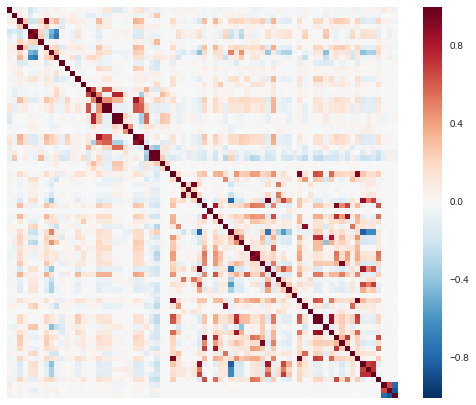

In [95]:
corr = data.corr()
corr.head()

## 86 different categories - start by taking correlation matrix to figure out which categories are redundant
f, ax = plt.subplots(figsize=(9,7))

# Draw the heatmap using seaborn
sns.heatmap(corr, square=True, cbar=True, xticklabels=False, yticklabels=False)

There are many visible families of variables encoding very similar information. Let's gather these sets of variables by turning them into a graph network. I've provided a solution using networkx below.

In [96]:
## thank you to stack overflow for the elegant solution: 
## http://stackoverflow.com/questions/4842613/merge-lists-that-share-common-elements
def to_graph(l):
    G = nx.Graph()
    for part in l:
        G.add_nodes_from(part)
        G.add_edges_from(to_edges(part))
    return G

def to_edges(l):
    """ 
        treat `l` as a Graph and returns it's edges 
        to_edges(['a','b','c','d']) -> [(a,b), (b,c),(c,d)]
    """
    it = iter(l)
    last = next(it)

    for current in it:
        yield last, current
        last = current    

The following function outputs a sorted list of all families of highly-correlated variables in a matrix. Takes in a dataframe of correlations and outputs a list of lists.

In [97]:
def find_families(corr_df, thresh):
    
    tentative_families = []

    ## for each variable, find each other variable that is highly correlated with, and put into list form.
    for name, col in corr_df.iteritems():

        highly_correlated = (abs(col) > thresh) & (col.index != name)
        high_corr_list = col[highly_correlated].index.tolist()

        #need to add the variable itself if the family is non-empty
        if high_corr_list != []:
            tentative_families.append(sorted(high_corr_list + [ name ]))

    tentative_families.sort()
    tentative_families = list(tentative_families for tentative_families,_ in itertools.groupby(tentative_families))
        
    ## use networkx class to convert list of connected nodes into a graph
    G = to_graph(tentative_families)
    cc = nx.connected_components(G)  ## returns a list of connected nodel elements
    families = []

    for nodes in cc:
        families.append(list(nodes))

    families = sorted([ sorted(fam) for fam in families ])

    ## let's print a list of all the families we've found
    for fam in families:
        print(fam, len(fam))
   
    ll = [ len(fam) for fam in families ]
    print("In total,", sum(ll), "variables found in", len(families), "families.")
    
    return families

For each variable in our data, we find a list of variables that it is highly correlated with, transform these linkages into a graph, and output families of connected nodes.

In [98]:
## cutoff of .6 recovers 47 inter-connected variables, .5 recovers 52, .55 recovers 50
## cutoff of .55 features largest group at length 10 - probably don't want to exceed that
cutoff = .55
families_1 = find_families(corr,cutoff)

['BoolEverWholeLoan', 'BoolIsFractionalLoan', 'EnumLoanFractionalType'] 3
['BoolOwnsHome', 'DolMonthlyDebt', 'DolRealEstateBalance', 'DolRealEstatePayment', 'DolTotalBalanceAllOpenTrades6', 'DolTotalBalanceInstallTradesReptd6', 'DolTotalPaymentAllOpenTrades6'] 7
['BorrowerRate', 'LenderYield', 'ProsperScore'] 3
['DolLoanAmountRequested', 'DolMonthlyLoanPayment'] 2
['DolMaxPriorProsperLoan', 'DolMinPriorProsperLoan', 'DolPriorProsperLoansBalanceOutstanding', 'DolPriorProsperLoansPrincipalBorrowed', 'DolPriorProsperLoansPrincipalOutstanding', 'NumPriorProsperLoans', 'NumPriorProsperLoansActive', 'NumPriorProsperLoansCyclesBilled', 'NumPriorProsperLoansEarliestPayOff', 'NumPriorProsperLoansOnTimePayments'] 10
['DolRevolvingBalance', 'DolTotalBalanceOpenRevolving6'] 2
['NumBankcardTradesOpened12', 'NumCreditLines84', 'NumCurrentCreditLines', 'NumOpenCreditLines', 'NumOpenRevolvingAccounts', 'NumSatisfactoryAccounts', 'NumTrades'] 7
['NumDelinquencies84', 'NumDelinquenciesOver30Days', 'NumD

I go through each family individually, give each one a name, and then choose a single variable to represent that family. Then, drop all of the variables in each family except for the chosen representative variable.

In [99]:
## give custom descriptive names to each family
# two items: first, each unit in the family; second, the variable(s) you're going to keep around.
family_dict = {}
family_dict['fractional_loan'] = [families_1[0],'BoolEverWholeLoan']
family_dict['debt'] = [families_1[1],'DolMonthlyDebt']
family_dict['borrower_rate'] = [families_1[2],'BorrowerRate']
family_dict['loan_amount'] = [families_1[3],'DolLoanAmountRequested']
family_dict['prosper_history'] = [families_1[4],'NumPriorProsperLoans']
family_dict['revolving_balance'] = [families_1[5],'DolTotalBalanceOpenRevolving6']
family_dict['credit'] = [families_1[6],'NumCurrentCreditLines']
family_dict['delinquencies'] = [families_1[7],'PctTradesNeverDelinquent']
family_dict['inquiries'] = [families_1[8],'NumTotalInquiries']
family_dict['prior_prosper_loans'] = [families_1[9],'NumPriorProsperLoans61dpd']
family_dict['real_estate'] = [families_1[10],'NumRealEstateTrades']
family_dict['current_delinquency'] = [families_1[11],'NumTradesCurr30DPDOrDerog6']

## leave original data unaltered, work with dataframe reduced_data instead...
reduced_data = pd.DataFrame.copy(data, deep = True)

In [100]:
## drop similar columns as determined by families
for fam, items in family_dict.items():
    drop_cols = list(items[0])
    drop_cols.remove(items[1]) #keep our chosen representative variable for that family
    reduced_data.drop(drop_cols, axis = 1, inplace = True)
    
print('New number of columns after first filtering:',len(reduced_data.columns.values))

## save this preliminary set of variables as a pickle file.
reduced_data.to_pickle('theorem_reduced_firstfilter.pkl')

New number of columns after first filtering: 48


Can take a quick look at remaining columns.

In [101]:
print(reduced_data.columns.values)

['ListingID' 'DateCreditPulled' 'DateListingStart' 'DateListingCreation'
 'EnumListingStatus' 'DolLoanAmountRequested' 'BoolPartialFundingApproved'
 'CreditGrade' 'BorrowerRate' 'NumMonthsTerm' 'FICOScore'
 'EnumListingCategory' 'DolMonthlyIncome' 'BoolIncomeVerifiable'
 'FracDebtToIncomeRatio' 'StrEmploymentStatus' 'StrOccupation'
 'NumMonthsEmployed' 'StrState' 'StrBorrowerCity' 'NumPriorProsperLoans'
 'NumPriorProsperLoansLateCycles' 'NumPriorProsperLoansLatePayments'
 'NumPriorProsperLoans61dpd' 'BoolIsLender' 'BoolInGroup' 'EnumChannelCode'
 'NumTradesOpened6' 'NumOpenTradesDelinqOrPastDue6'
 'NumTradesCurr30DPDOrDerog6' 'DolTotalBalanceOnPublicRecords'
 'AgeOldestTrade' 'PctTradesNeverDelinquent' 'DolTotalAvailBankcardCredit6'
 'NumRealEstateTrades' 'DolTotalBalanceOpenRevolving6' 'DolMonthlyDebt'
 'NumCurrentDelinquencies' 'NumPublicRecordsLast10Years'
 'NumPublicRecords12' 'DateFirstCredit' 'DolAmountDelinquent'
 'NumCurrentCreditLines' 'PctBankcardUtil' 'NumTotalInquiries'
 'D

Start looking at individual columns and remove extraneous columns such as dates and ID numbers. For instance, variables such as DateCreditPulled, DateListingCreation, DateListingStart and DateWholeLoanStart are unlikely to reflect consumer decision-making. Similarly, while there may be interesting things to be said about the influence of state/city on loan cancellation, they again shouldn't really strongly affect decision-making, and any effects are probably subordinate to direct economic effects.

In [102]:
## immediately drop columns that are unlikely/unable to cause loan cancellation (ID numbers/dates)
drop_cols = ['ListingID', 'DateCreditPulled', 'DateListingStart', 'DateListingCreation', 'DateWholeLoanStart', 'DateWholeLoanEnd']
reduced_data.drop(drop_cols, axis = 1, inplace = True)

## manually drop a few other columns that won't help this analysis.
reduced_data.drop(['StrState','StrBorrowerCity'], axis=1, inplace=True)

Although it's still too early to work with each column individual, some of these columns can be translated into more useful form - in particular, DateFirstCredit.

In [103]:
## replace DateFirstCredit column with an integer
days_since_firstcredit = datetime.now()-reduced_data['DateFirstCredit']
reduced_data['DaysSinceFirstCredit'] = [ x.days for x in days_since_firstcredit ]
reduced_data.drop('DateFirstCredit', axis=1, inplace=True)

Similarly, it turns out that CreditGrade encodes the same information as BorrowerRate, except with greater precision.

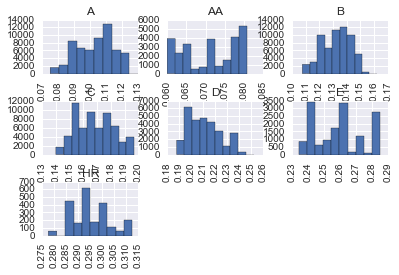

In [104]:
## quick plot to show that BorrowerRate and CreditGrade are pretty much equivalent - drop CreditGrade
reduced_data['BorrowerRate'].hist(by=reduced_data['CreditGrade'])
reduced_data.drop('CreditGrade',axis =1, inplace=True)

We're down to 39 columns.

In [105]:
print('New number of columns after removing variables:',len(reduced_data.columns.values))

New number of columns after removing variables: 39


Let's use the graph-family-correlation method again to further reduce the number of variables we're working with, this time with a lower threshold.

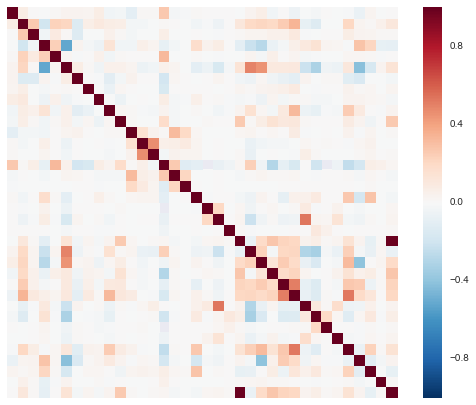

In [106]:
## show another correlation matrix, this time with reduced set of variables.
reduced_corr = reduced_data.corr()

f, ax = plt.subplots(figsize=(9,7))

# Draw the heatmap using seaborn
sns.heatmap(reduced_corr, square=True, cbar=True, xticklabels=False, yticklabels=False)

Still pockets of highly-correlated variables present, so let's rerun the method.

In [107]:
cutoff = .45
families_2 = find_families(reduced_corr,cutoff)

['AgeOldestTrade', 'DaysSinceFirstCredit'] 2
['BorrowerRate', 'DolTotalAvailBankcardCredit6', 'FICOScore', 'PctTradesNeverDelinquent'] 4
['DolMonthlyDebt', 'DolTotalBalanceOpenRevolving6', 'NumCurrentCreditLines'] 3
['NumCurrentDelinquencies', 'NumTradesCurr30DPDOrDerog6'] 2
['NumPriorProsperLoansLateCycles', 'NumPriorProsperLoansLatePayments'] 2
In total, 13 variables found in 5 families.


In [108]:
## give custom descriptive names to each family
# two items: first, each unit in the family; second, the variable(s) you're going to keep around.
family_dict_2 = {}
family_dict_2['oldest_trade'] = [families_2[0],'DaysSinceFirstCredit']
family_dict_2['borrower_rate'] = [families_2[1],'BorrowerRate']
family_dict_2['monthly_debt'] = [families_2[2],'DolMonthlyDebt']
family_dict_2['current_delinquencies'] = [families_2[3],'NumCurrentDelinquencies']
family_dict_2['prosper_delinquencies'] = [families_2[4],'NumPriorProsperLoansLatePayments']

## again, drop similar columns as determined by families
for fam, items in family_dict_2.items():
    drop_cols = list(items[0])
    drop_cols.remove(items[1]) #keep our chosen representative variable for that family
    reduced_data.drop(drop_cols, axis = 1, inplace = True)

In [109]:
print("Number of columns:",len(reduced_data.columns.values))
reduced_data.head()

Number of columns: 31


,EnumListingStatus,DolLoanAmountRequested,BoolPartialFundingApproved,BorrowerRate,NumMonthsTerm,EnumListingCategory,DolMonthlyIncome,BoolIncomeVerifiable,FracDebtToIncomeRatio,StrEmploymentStatus,StrOccupation,NumMonthsEmployed,NumPriorProsperLoans,NumPriorProsperLoansLatePayments,NumPriorProsperLoans61dpd,BoolIsLender,BoolInGroup,EnumChannelCode,NumTradesOpened6,NumOpenTradesDelinqOrPastDue6,DolTotalBalanceOnPublicRecords,NumRealEstateTrades,DolMonthlyDebt,NumCurrentDelinquencies,NumPublicRecordsLast10Years,NumPublicRecords12,DolAmountDelinquent,PctBankcardUtil,NumTotalInquiries,BoolEverWholeLoan,DaysSinceFirstCredit
ListingNumber,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
973605,7,15000.0,True,0.1620,60,1,6000.0000,True,0.27,Employed,Tradesman - Mechanic,445.0,0,NaN,NaN,0,False,70000,1,0,0,2,1242,0,0,0,0,0.97,5,True,13920
981099,7,15000.0,True,0.1585,60,1,7916.6667,True,0.35,Other,NaN,32.0,0,NaN,NaN,0,False,70000,1,0,0,2,2289,0,0,0,0,0.48,3,True,14257
1025766,6,4000.0,True,0.2085,36,1,2083.3333,True,0.53,Employed,Professional,4.0,3,0.0,NaN,0,False,80000,0,0,0,0,911,0,0,0,0,0.93,5,False,4165
1003835,7,10000.0,True,0.1299,36,13,3750.0000,True,0.14,Employed,Medical Technician,2.0,0,NaN,NaN,0,False,90000,1,0,0,0,223,0,0,0,0,0.26,1,True,2961
1011335,6,20000.0,True,0.1440,60,1,9000.0000,True,0.16,Employed,Executive,90.0,1,0.0,NaN,0,False,80000,1,0,1249,1,1264,1,2,0,0,0.81,17,False,8348


A closer look at BoolIncomeVerifiable shows that it is completely equivalent to StrEmploymentStatus - can safely drop.

In [110]:
print('BoolIncomeVerifiable is false:\n', \
      reduced_data[reduced_data['BoolIncomeVerifiable'] == False]['StrEmploymentStatus'].value_counts(normalize = True))
print('BoolIncomeVerifiable is true:\n', \
      reduced_data[reduced_data['BoolIncomeVerifiable'] == True]['StrEmploymentStatus'].value_counts(normalize = True))

reduced_data.drop('BoolIncomeVerifiable', axis = 1, inplace = True)

BoolIncomeVerifiable is false:
 Self-employed    0.999616
Not employed     0.000256
Employed         0.000128
Name: StrEmploymentStatus, dtype: float64
BoolIncomeVerifiable is true:
 Employed         0.914816
Other            0.082516
Full-time        0.002592
Self-employed    0.000055
Part-time        0.000021
Name: StrEmploymentStatus, dtype: float64


Last change: Logistic regression requires that the target variable be either 0 or 1, so let's create a new variable called "Cancelled" which is just EnumListingStatus minus 6.

In [111]:
## replace EnumListingStatus with Cancelled
reduced_data['Cancelled'] = reduced_data['EnumListingStatus']-6
reduced_data.drop('EnumListingStatus', axis=1, inplace = True)

In [112]:
## save to pickle file again.
reduced_data.to_pickle('theorem_reduced_secondfilter.pkl')

In [113]:
## What's left:
print(reduced_data.columns.values)

['DolLoanAmountRequested' 'BoolPartialFundingApproved' 'BorrowerRate'
 'NumMonthsTerm' 'EnumListingCategory' 'DolMonthlyIncome'
 'FracDebtToIncomeRatio' 'StrEmploymentStatus' 'StrOccupation'
 'NumMonthsEmployed' 'NumPriorProsperLoans'
 'NumPriorProsperLoansLatePayments' 'NumPriorProsperLoans61dpd'
 'BoolIsLender' 'BoolInGroup' 'EnumChannelCode' 'NumTradesOpened6'
 'NumOpenTradesDelinqOrPastDue6' 'DolTotalBalanceOnPublicRecords'
 'NumRealEstateTrades' 'DolMonthlyDebt' 'NumCurrentDelinquencies'
 'NumPublicRecordsLast10Years' 'NumPublicRecords12' 'DolAmountDelinquent'
 'PctBankcardUtil' 'NumTotalInquiries' 'BoolEverWholeLoan'
 'DaysSinceFirstCredit' 'Cancelled']


This is the final set of variables that we're going to start investigating. We've gone from 86 columns down to 31 columns. Here's a breakdown of what remains:

* Target: Cancelled
* Numerical variables: DolLoanAmountRequested, BorrowerRate, NumMonthsTerm, DolMonthlyIncome, FracDebtToIncomeRatio, NumMonthsEmployed, NumPriorProsperLoans, NumPriorProsperLoansLatePayments, NumPriorProsperLoans61dpd, NumTradesOpened6, NumOpenTradesDelinqOrPastDue6, DolTotalBalanceOnPublicRecords, NumRealEstateTrades, DolMonthlyDebt, NumCurrentDelinquencies, NumPublicRecordsLast10Years, NumPublicRecords12, DolAmountDelinquent, PctBankcardUtil, NumTotalInquiries, DaysSinceFirstCredit (21)
* Categorical variables: EnumListingCategory, StrEmploymentStatus, StrOccupation, EnumChannelCode (4)
* Boolean variables: BoolPartialFundingApproved, BoolIsLender, BoolInGroup, BoolEverWholeLoan (5)

Many of these variables have strange distributions, and will have to be treated individually. In particular, some of these variables are likely better suited to be bools, as demonstrated shortly, and others have large numbers of NaNs that we'll have to figure out what to do with.

Time to visualize the data! NumPriorProsperLoans61dpd is left out because, on closer inspection, all but 50 of the rows have NaNs in that variable. We also use NumPublicRecordsLast10Years instead of NumPublicRecords12 to explore link between public records and cancellation.

In [114]:
## only 50 people have a non-zero value for this criterion!
sum(np.isnan(reduced_data['NumPriorProsperLoans61dpd']))
reduced_data['NumPriorProsperLoans61dpd'].value_counts()

## similarly, very few people have a public record from the last 12 months - let's use 10-year version instead for now
sum(np.isnan(reduced_data['NumPublicRecords12']))
reduced_data['NumPublicRecords12'].value_counts()

0    251457
1       894
2        92
3        18
4         7
6         1
Name: NumPublicRecords12, dtype: int64

In [ ]:
## 19 numerical variables only - show plot for each one. Also include column for cancellation.
numerics = reduced_data[['DolLoanAmountRequested','BorrowerRate','NumMonthsTerm','DolMonthlyIncome','FracDebtToIncomeRatio',\
'NumMonthsEmployed','NumPriorProsperLoans','NumPriorProsperLoansLatePayments',\
'NumTradesOpened6','NumOpenTradesDelinqOrPastDue6','DolTotalBalanceOnPublicRecords','NumRealEstateTrades',\
'DolMonthlyDebt','NumCurrentDelinquencies','NumPublicRecordsLast10Years','DolAmountDelinquent','PctBankcardUtil',\
'NumTotalInquiries','DaysSinceFirstCredit']]

In [ ]:
## create one big figure behind subpanels
fig, axes = plt.subplots(6,3,figsize=(12,16), facecolor='w')

## cycle through each numeric variable and logistic regress with cancellation (excluding cancellation itself)
for ax, var in zip(axes.reshape(-1),numerics.columns.values):
    sns.regplot(ax=ax, x=var, y="Cancelled", data=reduced_data, logistic=True, ci = None, x_bins = 200)

* Variables that immediately appear to show a strong correlation with loan cancellation: DolLoanAmountRequested, DolMonthlyIncome,FracDebtToIncomeRatio,NumMonthsEmployed,NumTradesOpened6, NumOpenTradesDelinqOrPastDue6, NumRealEstateTrades, DolMonthlyDebt, NumCurrentDelinquencies, PctBankcardUtil, NumTotalInquiries.

* A few variables immediately seem to demonstrate nonlinear behavior, most notably DaysSinceFirstCredit, DolMonthlyDebt, NumMonthsEmployed and maybe even BorrowerRate. That said, I'm reluctant to add non-linear terms to my eventual model for risk of overfitting.

* NumPriorProsperLoans is a great predictor of whether you cancel or not. This makes some intuitive sense - if you've been through the process before, much easier to follow through. In fact, a boolean variable seems more appropriate, which we implement immediately below.

In [ ]:
fig, ax = plt.subplots()
sns.regplot(x="NumPriorProsperLoans", y="Cancelled", data=reduced_data, logistic=True, ci = None, x_bins = 500)

There's no evidence that taking out more than one loans actually makes you less likely to cancel, so a logistic regression of the number of loans is a poor model. Let's change this variable to a boolean parameter instead.

In [ ]:
#Create new Boolean variable that shows whether someone has ever taken out a Prosper loan before or not.
reduced_data['BoolPriorProsperLoanee'] = reduced_data['NumPriorProsperLoans'] > 0
reduced_data.drop('NumPriorProsperLoans', inplace = True, axis =1)

As we did above for the numerical variables, let's check out the influence of the boolean variables in our set.

In [ ]:
## 5 boolean variables to consider.
booleans = reduced_data[['BoolPriorProsperLoanee','BoolPartialFundingApproved','BoolIsLender','BoolInGroup','BoolEverWholeLoan']]

In [ ]:
## create one big figure behind subpanels
fig, axes = plt.subplots(3,2,figsize=(8,10), facecolor='w')

## cycle through each numeric variable and logistic regress with cancellation (excluding cancellation itself)
for ax, var in zip(axes.reshape(-1), booleans.columns.values):
    sns.regplot(ax=ax, x=var, y="Cancelled", data=reduced_data, logistic=True, ci = None, x_bins = 500)

BoolPriorProsperLoanee is highly significant, BoolIsLender and BoolInGroup also look significant, 
BoolPartialFundingApproved and BoolEverWholeLoan do not. We drop the latter two variables right away.

In [ ]:
reduced_data.drop(['BoolPartialFundingApproved','BoolEverWholeLoan'], inplace = True, axis =1)

In [ ]:
print(reduced_data['BoolPriorProsperLoanee'].value_counts(normalize = True))
print(reduced_data['BoolIsLender'].value_counts(normalize = True))
print(reduced_data['BoolInGroup'].value_counts(normalize = True))

Even though these variables all looked significant, BoolIsLender and BoolInGroup are only true for a very small subset of the total loan population - therefore including them into our model probably won't improve skill very much. We'll still keep them in as candidate variables for now.

In [ ]:
reduced_data.to_pickle('theorem_model_variables_test.pkl')

We added a couple of variables and dropped others based on our findings above - let's save our final variable pool.

# Building a logistic model

### First parameters

The plot above gives us a good idea of a few variables that make a big difference, including DolLoanAmountRequested, BoolPriorProsperLoanee and PctBankcardUtil. Loanees are more likely to cancel if the amount of the loan is higher, less likely to cancel if they have received a Prosper loan before, and less likely to cancel with higher bank card utilization. Let's plot some ROC curves for these variables, and also test out another variable, NumTotalInquiries.

In [ ]:
variables = [['DolLoanAmountRequested'],['BoolPriorProsperLoanee','DolLoanAmountRequested'],\
       ['BoolPriorProsperLoanee','DolLoanAmountRequested','PctBankcardUtil'],\
            ['BoolPriorProsperLoanee','DolLoanAmountRequested','PctBankcardUtil','NumTotalInquiries']]

y = reduced_data['Cancelled']
X = []
X_train = []
X_test = []
y_train = []
y_test = []

fig, ax = plt.subplots()

for i,v in enumerate(variables):
    standard_scaler = preprocessing.StandardScaler()
    X.append(standard_scaler.fit_transform(reduced_data[v]))
    X_tr, X_te, y_tr, y_te = train_test_split(X[i], y, test_size=0.3, random_state=0)
    logm = linear_model.LogisticRegression()
    logm.fit(X_tr,y_tr)
    probs = logm.predict_proba(X_te)
    fpr, tpr, thresholds = metrics.roc_curve(y_te,probs[:,1])

    ## make plot of ROC curve
    l, = ax.plot(fpr,tpr, label = 'a')
    print(logm.coef_)

plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize = 16)
plt.xlabel('FPR (False Positive Rate)', fontsize=14)
plt.ylabel('TPR (True Positive Rate)', fontsize=14)

handles, labels = ax.get_legend_handles_labels()
mylabels = ['DolLoanAmountRequested','BoolPriorProsperLoanee, DolLoanAmountRequested',\
       'BoolPriorProsperLoanee, DolLoanAmountRequested,\nPctBankcardUtil',\
            'BoolPriorProsperLoanee, DolLoanAmountRequested,\nNumTotalInquiries, PctBankcardUtil']
legend = ax.legend(handles[::-1], labels = mylabels, loc = 2)

#show the "no-skill" line
ax.plot([0, 1], [0, 1], color='navy', linestyle='--')

This series of ROC curves shows that starting with DolLoanAmountRequested, then adding BoolPriorProsperLoanee, then PctBankcardUtil, all make successive contributions to quality of fit. On the other hand, adding NumTotalInquiries makes a relatively minor impact on the resulting ROC curve, so we should consider leaving it out.

### Employment Status

Next, let's figure out how to treat the categorical variable StrEmploymentStatus.

In [ ]:
print(reduced_data['StrEmploymentStatus'].value_counts())
print(reduced_data.groupby('StrEmploymentStatus')['Cancelled'].mean())

Clearly, self-reported employment status makes a huge difference on the probability of cancellation, especially if potential loanees list themselves as "Other." Let's file the last two categories as Other to reduce the number of categories and convert StrEmploymentStatus to dummy variables.

In [ ]:
## important step...let's test the treatment of the categorical variable.
reduced_data['StrEmploymentStatus'].replace(['Part-time','Not employed'],'Other',inplace = True)
X_job = reduced_data['StrEmploymentStatus'].to_frame()
X_dummies = pd.get_dummies(X_job)

## these are the core variables we've already identified
variables = ['BoolPriorProsperLoanee','DolLoanAmountRequested','PctBankcardUtil']
X = reduced_data[variables]

#y = reduced_data['Cancelled']
X_without_jobs = reduced_data[variables]
X_with_jobs = pd.concat([X,X_dummies], axis=1)

In [ ]:
## let's plot 3 curves - accounting for job status only
fig, ax = plt.subplots()

standard_scaler1 = preprocessing.StandardScaler()
X_without_jobs_sc = standard_scaler1.fit_transform(X_without_jobs)

standard_scaler2 = preprocessing.StandardScaler()
X_with_jobs_sc = standard_scaler2.fit_transform(X_with_jobs)

for X in [X_dummies, X_without_jobs_sc, X_with_jobs_sc]:
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=0)
    logm = linear_model.LogisticRegression()
    logm.fit(X_tr,y_tr)
    probs = logm.predict_proba(X_te)
    fpr, tpr, thresholds = metrics.roc_curve(y_te,probs[:,1])
    plt.plot(fpr,tpr)
    print(logm.coef_)
    
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize = 16)
plt.xlabel('FPR (False Positive Rate)', fontsize=14)
plt.ylabel('TPR (True Positive Rate)', fontsize=14)

handles, labels = ax.get_legend_handles_labels()
mylabels = ['StrEmploymentStatus only','3 vars without job status','3 vars with job status']
legend = ax.legend(handles, labels = mylabels, loc = 2)

## draw the "no-skill" line
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

Adding job type notably increases area under curve, especially at the fringes - again, small sub-populations (like
those who respond 'other' as job status) where we're able to make much stronger predictions. StrEmploymentStatus is added as the fourth core variable of the model.

### Monthly Debt/Monthly Income/Debt-To-Income Ratio

Rather than trying to introduce these variables separately, they are clearly inter-related to one another (although as we'll see below, FracDebtToIncomeratio is not exactly equal to DolMonthlyDebt/DolMonthlyIncome). Therefore, I tested the possible combinations of these variables to see which had the best predictivity for loan cancellation (rather than just plugging each in individually).

In [ ]:
print('Does variable contain any NaNs?')
reduced_data.isnull().any()

One immediate problem - some values of DolMonthlyIncome are null. Let's figure out why.

In [ ]:
DI_null = reduced_data[reduced_data['FracDebtToIncomeRatio'].isnull()]
print(DI_null['StrEmploymentStatus'].value_counts())

15605 of 15624 loanees listed as Self-employed don't have a value for FracDebtToIncomeRatio. Let's fix that by creating a pseudo-value based on the observed relationships for other kinds of jobs.

In [ ]:
## make a smaller data-frame just with DolMonthlyDebt, DolMonthlyIncome and FracDebtToIncomeRatio.
test_df = reduced_data[['DolMonthlyDebt','DolMonthlyIncome','FracDebtToIncomeRatio']]
test_df['PreliminaryDTI'] = test_df['DolMonthlyDebt']/test_df['DolMonthlyIncome']

## first try - let's compare the variable FracDebtToIncomeRatio to what we get by dividing DolMonthlyDebt to DolMonthlyIncome.
test_df['prelim_vs_actual_frac'] = test_df['PreliminaryDTI']/test_df['FracDebtToIncomeRatio']

## key line below - a very small amount of loanees have a reported DolMonthlyIncome of 0, in which case the fraction is infinite
test_df.replace([np.inf, -np.inf], np.nan, inplace = True)
print("Mean ratio between our estimated Debt-to-Income ratio and actual:", test_df['prelim_vs_actual_frac'].mean())
print("Standard deviation:", test_df['prelim_vs_actual_frac'].std())

fig,ax = plt.subplots()
test_df['prelim_vs_actual_frac'].hist(bins = 100)
plt.title('Ratio of estimated Debt-to-Income Ratio versus Actual', size = 14)

Ad hoc formula for creating a pseudo-Debt-to-Income ratio: divide DolMonthlyDebt by DolMonthlyIncome, then scale by factor of 1/.6933 (about 1.442)

In [ ]:
## let's make the pseudo-variable.
## Two steps: 1) Use FracDebtToIncomeRatio where available. 2) Otherwise, estimate it using method described just above.
test_df['EstimatedDebtToIncomeRatio'] = test_df['FracDebtToIncomeRatio']
test_df.ix[np.isnan(test_df.EstimatedDebtToIncomeRatio), 'EstimatedDebtToIncomeRatio'] = test_df['PreliminaryDTI']/.6933
test_df[:20]

Now, let's try out some models with different combinations of variables, starting with individual variables.

In [ ]:
cols_debt_income = [['DolMonthlyDebt'],['DolMonthlyIncome'],['EstimatedDebtToIncomeRatio']]

fig, ax = plt.subplots()

for cols in cols_debt_income:
    X_debt = test_df[cols]
    standard_scaler2 = preprocessing.StandardScaler()
    X_debt_sc = standard_scaler2.fit_transform(X_debt)
    X_tr, X_te, y_tr, y_te = train_test_split(X_debt_sc, y, test_size=0.3, random_state=0)
    logm = linear_model.LogisticRegression()
    logm.fit(X_tr,y_tr)
    probs = logm.predict_proba(X_te)
    fpr, tpr, thresholds = metrics.roc_curve(y_te,probs[:,1])
    plt.plot(fpr,tpr)
    print(logm.coef_)
    
plt.title('ROC curves for single variables', fontsize = 16)
plt.xlabel('FPR (False Positive Rate)', fontsize=14)
plt.ylabel('TPR (True Positive Rate)', fontsize=14)

handles, labels = ax.get_legend_handles_labels()
mylabels = ['DolMonthlyDebt','DolMonthlyIncome','EstimatedDebtToIncomeRatio']
legend = ax.legend(handles, labels = mylabels, loc = 2)

## draw the "no-skill" line
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

If we were going to pick a single variable, DolMonthlyDebt would perform best  and EstimatedDebtToIncomeRatio not too much worse, while DolMonthlyIncome would have very little predictivity.

In [ ]:
cols_debt_income = [['DolMonthlyDebt','DolMonthlyIncome'],\
      ['DolMonthlyDebt','EstimatedDebtToIncomeRatio'],\
      ['DolMonthlyIncome','EstimatedDebtToIncomeRatio']]

fig, ax = plt.subplots()

for cols in cols_debt_income:
    X = test_df[cols]
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=0)
    logm = linear_model.LogisticRegression()
    logm.fit(X_tr,y_tr)
    probs = logm.predict_proba(X_te)
    fpr, tpr, thresholds = metrics.roc_curve(y_te,probs[:,1])
    plt.plot(fpr,tpr)
    print(logm.coef_)
    
plt.title('ROC curves for single variables', fontsize = 16)
plt.xlabel('FPR (False Positive Rate)', fontsize=14)
plt.ylabel('TPR (True Positive Rate)', fontsize=14)

handles, labels = ax.get_legend_handles_labels()
mylabels = ['DolMonthlyDebt + DolMonthlyIncome','DolMonthlyDebt + EstimatedDebtToIncomeRatio',\
           'DolMonthlyIncome + EstimatedDebtToIncomeRatio']
legend = ax.legend(handles, labels = mylabels, loc = 2)

## draw the "no-skill" line
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

Perhaps surprisingly, even though DolMonthlyIncome wasn't useful individually, works better in tandem with DolMonthlyDebt than EstimatedDebtToIncomeRatio.

In [ ]:
cols_debt_income = [['DolMonthlyDebt'],['DolMonthlyDebt','DolMonthlyIncome'],\
                   ['DolMonthlyDebt','DolMonthlyIncome','EstimatedDebtToIncomeRatio']]

fig, ax = plt.subplots()
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

for cols in cols_debt_income:
    X = test_df[cols]
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=0)
    logm = linear_model.LogisticRegression()
    logm.fit(X_tr,y_tr)
    probs = logm.predict_proba(X_te)
    fpr, tpr, thresholds = metrics.roc_curve(y_te,probs[:,1])
    plt.plot(fpr,tpr)
    print(logm.coef_)
    
handles, labels = ax.get_legend_handles_labels()
mylabels = ['DolMonthlyDebt','DolMonthlyDebt + DolMonthlyIncome',\
           'DolMonthlyDebt + DolMonthlyIncome + EstimatedDebtToIncomeRatio']
legend = ax.legend(handles, labels = mylabels, loc = 2)

## draw the "no-skill" line
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

The last plot above shows that adding EstimatedDebtToIncomeRatio doesn't add skill to the combo of DolMonthlyDebt and DolMonthlyIncome - therefore, we get to leave it out entirely. It makes sense that one of the three variables should be omitted, since they are clearly not independent from one another. Let's take a look at the improvement in skill by including these two variables:

In [ ]:
X_nodebt = X_with_jobs 
X_withdebt = pd.concat([X_nodebt,reduced_data[['DolMonthlyDebt','DolMonthlyIncome']]], axis=1)
X_withdebt.head()

In [ ]:
fig, ax = plt.subplots()

## scale the variables first
X_nodebt_sc = X_with_jobs_sc
standard_scaler = preprocessing.StandardScaler()
X_withdebt_sc = standard_scaler.fit_transform(X_withdebt)

for X in [X_nodebt_sc, X_withdebt_sc]:
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=0)
    logm = linear_model.LogisticRegression()
    logm.fit(X_tr,y_tr)
    probs = logm.predict_proba(X_te)
    fpr, tpr, thresholds = metrics.roc_curve(y_te,probs[:,1])
    plt.plot(fpr,tpr)
    print(logm.coef_)
    
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize = 16)
plt.xlabel('FPR (False Positive Rate)', fontsize=14)
plt.ylabel('TPR (True Positive Rate)', fontsize=14)

handles, labels = ax.get_legend_handles_labels()
mylabels = ['Without Monthly Debt/Income','With Monthly Debt/Income']
legend = ax.legend(handles, labels = mylabels, loc = 2)

## draw the "no-skill" line
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

### Borrower Rate and Real Estate Trades
From our variable-by-variable logistic regressions above, it seemed that BorrowerRate and NumRealEstateTrades both had a weak influence on cancellation probability. Let's test it out here.

In [ ]:
X_borrower_rate = pd.concat([X_withdebt,reduced_data[['BorrowerRate']]], axis=1)
X_full = pd.concat([X_withdebt,reduced_data[['BorrowerRate','NumRealEstateTrades']]], axis=1)

fig, ax = plt.subplots()

## scale the variables first
standard_scaler = preprocessing.StandardScaler()
X_borrower_rate_sc = standard_scaler.fit_transform(X_borrower_rate)

standard_scaler_2 = preprocessing.StandardScaler()
X_full_sc = standard_scaler.fit_transform(X_full)

for X in [X_withdebt_sc, X_borrower_rate_sc, X_full_sc]:
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=0)
    logm = linear_model.LogisticRegression()
    logm.fit(X_tr,y_tr)
    probs = logm.predict_proba(X_te)
    fpr, tpr, thresholds = metrics.roc_curve(y_te,probs[:,1])
    plt.plot(fpr,tpr)
    print(logm.coef_)
    
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize = 16)
plt.xlabel('FPR (False Positive Rate)', fontsize=14)
plt.ylabel('TPR (True Positive Rate)', fontsize=14)

handles, labels = ax.get_legend_handles_labels()
mylabels = ['BoolPriorProsperLoanee, DolLoanAmountRequested, PctBankcardUtil,\n\
StrEmploymentStatus, DolMonthlyDebt and DolMonthlyIncome', '+ BorrowerRate','+ BorrowerRate + NumRealEstateTrades']
legend = ax.legend(handles, labels = mylabels, loc = 2)

## draw the "no-skill" line
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

The coefficient for BorrowerRate is smaller in magnitude than for other variables, but it does make a noticeable difference in the center of our ROC curve, and so I include it in the final model. For other variables such as BoolPriorProsperLoanee which only affect a small percentage of loanees (less than 10%), the effect is primarily on the fringes of the ROC curve. Even though the BorrowerRate effect is small (higher borrower rate leads to slightly higher probability of cancellation), it still provides added information for every loan.

## Are we missing any significant variables?
As it stands, the model includes BoolPriorProsperLoanee (derived from NumPriorProsperLoans), DolLoanAmountRequested, PctBankcardUtil, StrEmploymentStatus, DolMonthlyDebt, DolMonthlyIncome, BorrowerRate and NumRealEstateTrades, for 8 variables in total (11 if we account for treating StrEmploymentStatus with dummy variables). Let's test out a few other possibly important variables to see if we're missing anything.

## Categorical variables
We still have EnumChannelCode, EnumListingCategory and StrOccupation to evaluate, since they require prior treatment before determining their influence

In [48]:
channel_codes = reduced_data.groupby('EnumChannelCode')
print(channel_codes['Cancelled'].mean())


EnumChannelCode
40000    0.347317
50000    0.350827
70000    0.369273
80000    0.133648
90000    0.341167
Name: Cancelled, dtype: float64


EnumChannelCode looks promising, but there's a catch:

In [49]:
channel_codes.get_group('80000')['BoolPriorProsperLoanee'].mean()

1.0

An EnumChannelCode of 80000 just refers to a new potential Prosper loanee, so no new information - can go ahead and discard.

In [50]:
listing_category = reduced_data.groupby('EnumListingCategory')
print(listing_category['Cancelled'].sum())
print(listing_category['Cancelled'].mean())

EnumListingCategory
0        81
1     62989
2      4453
3      2659
6       846
7      6687
8       134
9        55
11      112
12       57
13      933
14     1627
15     2111
16      104
17       60
18      400
19      581
20      497
21       31
Name: Cancelled, dtype: int64
EnumListingCategory
0     0.355263
1     0.322420
2     0.352350
3     0.421997
6     0.374668
7     0.376605
8     0.330864
9     0.343750
11    0.336336
12    0.518182
13    0.343267
14    0.402126
15    0.394137
16    0.371429
17    0.410959
18    0.269542
19    0.431329
20    0.351734
21    0.244094
Name: Cancelled, dtype: float64


Let's test out whether including StrOccupation (as opposed to just StrEmploymentStatus) can improve predictions.

In [51]:
X_occupation = reduced_data['StrOccupation'].to_frame()
X_occupation_dummies = pd.get_dummies(X_occupation)
X_full_plus_occupation = pd.concat([X_full,X_occupation_dummies], axis=1)

[[-0.28483716  0.2253451  -0.15113019 -0.02038505 -0.01987256  0.17816365
  -0.16407718 -0.14316928  0.41307171  0.07629983 -0.09721096]]
[[-0.13988701 -0.11243354 -0.19726335 -0.0387766  -0.06955507 -0.02288684
  -0.02038457 -0.0288002  -0.02931209 -0.12385895 -0.01053592 -0.13081067
  -0.19363732 -0.06645952  0.00158623 -0.02865449 -0.02834915 -0.09650302
  -0.10054635 -0.13979454 -0.05011273 -0.01281783 -0.01849313 -0.04731646
   0.01281186 -0.01631909 -0.01076619 -0.04727013 -0.01974722 -0.0641389
  -0.07892993 -0.05111772 -0.03700485 -0.14938569 -0.01282368 -0.36824531
  -0.04377648 -0.02763206 -0.12465132 -0.0722801  -0.04448395 -0.29948321
  -0.07279584 -0.02758296 -0.0170099   0.00431347 -0.10395401 -0.08424547
  -0.07310506 -0.0604576  -0.10677303 -0.06517976  0.00651405 -0.00700254
  -0.0082082  -0.01255882  0.01310073 -0.01062916  0.00570835 -0.14516898
  -0.00739753 -0.01865269 -0.05590363 -0.07799285 -0.00738032 -0.06424568
  -0.0025789 ]]
[[ -2.72537026e-01   2.51202990e-

//anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:492: UserWarning: You have mixed positional and keyword arguments, some input will be discarded.
  warnings.warn("You have mixed positional and keyword "


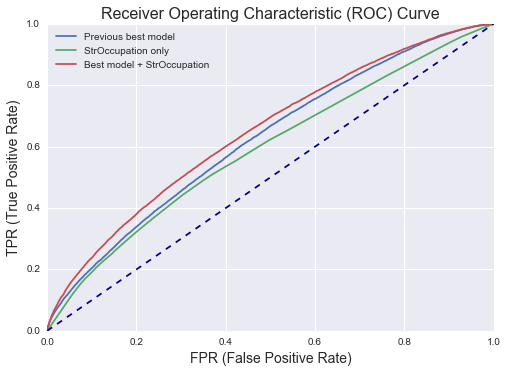

In [52]:
fig, ax = plt.subplots()

## scale the variables first
standard_scaler = preprocessing.StandardScaler()
X_occupation_sc = standard_scaler.fit_transform(X_occupation_dummies)

standard_scaler_2 = preprocessing.StandardScaler()
X_full_plus_occupation_sc = standard_scaler.fit_transform(X_full_plus_occupation)

for X in [X_full_sc, X_occupation_sc, X_full_plus_occupation_sc]:
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=0)
    logm = linear_model.LogisticRegression()
    logm.fit(X_tr,y_tr)
    probs = logm.predict_proba(X_te)
    fpr, tpr, thresholds = metrics.roc_curve(y_te,probs[:,1])
    plt.plot(fpr,tpr)
    print(logm.coef_)
    
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize = 16)
plt.xlabel('FPR (False Positive Rate)', fontsize=14)
plt.ylabel('TPR (True Positive Rate)', fontsize=14)

handles, labels = ax.get_legend_handles_labels()
mylabels = ['Previous best model','StrOccupation only','Best model + StrOccupation']
legend = ax.legend(handles, labels = mylabels, loc = 2)

## draw the "no-skill" line
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

I'm reluctant to add StrOccupation because it adds so many variables to the model, but it also shows great predictive skill both on its own and when appended to the other variables. Furthermore, adding StrOccupation as a dummy variable doesn't strongly affect the previously calculated coefficients for the other variables in our model. Let's include it for now.

In [53]:
X_final = X_full_plus_occupation
X_final_sc = X_full_plus_occupation_sc

## save the final set of variables to pickle file for easy reload.
X_final.to_pickle('theorem_reduced_finalmodel.pkl')
y.to_pickle('cancelled.pkl')

### Remaining boolean variables

We have two remaining variables that seem to show strong predictivity of loan cancellation: BoolIsLender and BoolInGroup. The problem as shown below is that there are very few loanees for whom either variable are true, and so including them will only add predictive skill to about 1% of loans.

In [54]:
print(reduced_data['BoolIsLender'].value_counts())
print(reduced_data['BoolInGroup'].value_counts())

0    249330
1      3139
Name: BoolIsLender, dtype: int64
False    251804
True        665
Name: BoolInGroup, dtype: int64


[[ -2.72537026e-01   2.51202990e-01  -1.47020800e-01   5.07375822e-02
   -8.71945801e-03   7.17501457e-02  -1.51265998e-01  -1.23899513e-01
    4.40138153e-01   6.79449587e-02  -9.04484644e-02  -1.22318391e-01
   -8.94882999e-02  -1.84670732e-01  -3.49498618e-02  -5.18228297e-02
   -1.79952255e-02  -1.07225912e-02  -2.23918108e-02  -2.74004768e-02
   -1.14499078e-01  -1.24555313e-03  -1.04459456e-01  -1.87292586e-01
   -4.01921848e-02   8.26737095e-03  -2.44403431e-02  -2.72407227e-02
   -9.25625638e-02  -9.51468693e-02  -1.32346806e-01  -4.83430916e-02
   -1.13050462e-02  -4.85790299e-04  -3.47169006e-02   2.77446536e-02
    5.91900541e-03  -8.23770200e-03  -2.87657666e-02   3.27352116e-03
   -5.37034610e-02  -7.36518523e-02  -4.94694895e-02  -2.89884719e-02
   -1.44347597e-01   5.80130904e-06  -3.12010633e-01  -4.33994523e-02
   -2.74189196e-02  -1.15207227e-01  -6.55230205e-02  -3.92441143e-02
   -2.67139324e-01  -6.70890155e-02  -1.89025546e-02   1.42576109e-02
    1.28344643e-02  

//anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:492: UserWarning: You have mixed positional and keyword arguments, some input will be discarded.
  warnings.warn("You have mixed positional and keyword "


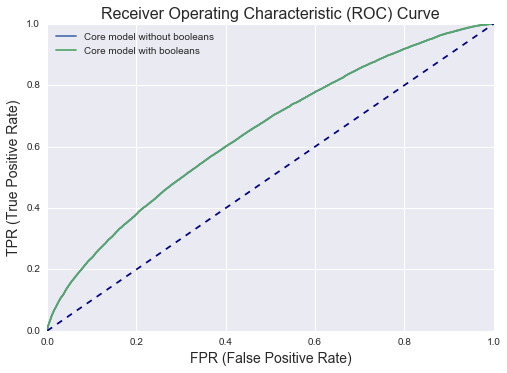

In [55]:
X_bool_test= pd.concat([X_final,reduced_data[['BoolIsLender','BoolInGroup']]], axis=1)

fig, ax = plt.subplots()

## scale the variables first
standard_scaler = preprocessing.StandardScaler()
X_bool_test_sc = standard_scaler.fit_transform(X_bool_test)

for X in [X_final_sc, X_bool_test_sc]:
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=0)
    logm = linear_model.LogisticRegression()
    logm.fit(X_tr,y_tr)
    probs = logm.predict_proba(X_te)
    fpr, tpr, thresholds = metrics.roc_curve(y_te,probs[:,1])
    plt.plot(fpr,tpr)
    print(logm.coef_)
    
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize = 16)
plt.xlabel('FPR (False Positive Rate)', fontsize=14)
plt.ylabel('TPR (True Positive Rate)', fontsize=14)

handles, labels = ax.get_legend_handles_labels()
mylabels = ['Core model without booleans','Core model with booleans']
legend = ax.legend(handles, labels = mylabels, loc = 2)

## draw the "no-skill" line
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

No perceptible difference exists between including or excluding BoolIsLender and BoolInGroup, so we leave them out of the model.

### Remaining numerical variables

A list of numerical variables that we haven't put into the model yet:
DolTotalBalanceOnPublicRecords, NumMonthsTerm, NumMonthsEmployed, NumPriorProsperLoansLatePayments, NumPriorProsperLoans61dpd, NumTradesOpened6, NumOpenTradesDelinqOrPastDue6, NumCurrentDelinquencies, NumPublicRecordsLast10Years, NumPublicRecords12, DolAmountDelinquent, DaysSinceFirstCredit

### DaysSinceFirstCredit and NumMonthsEmployed
As shown below, these two variables are unsurprisingly highly correlated.

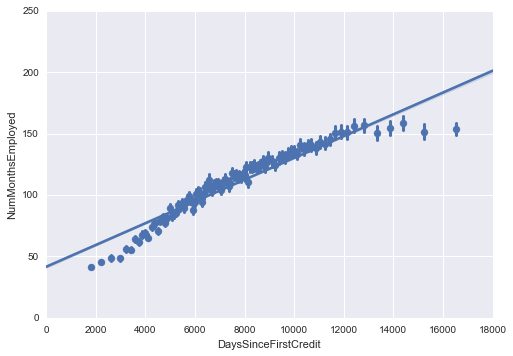

In [56]:
sns.regplot(reduced_data['DaysSinceFirstCredit'],reduced_data['NumMonthsEmployed'],x_bins=100)

However, there's clearly something unusual going on at both extremes with old and young lenders, as shown by repeating the regression with each of these two variables below.

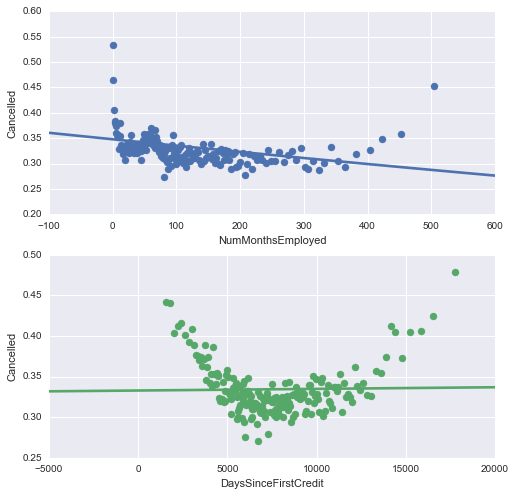

In [57]:
date_vars = reduced_data[['NumMonthsEmployed','DaysSinceFirstCredit']]

## create one big figure behind subpanels
fig, axes = plt.subplots(2,1,figsize=(8,8), facecolor='w')

## cycle through each numeric variable and logistic regress with cancellation (excluding cancellation itself)
for ax, var in zip(axes.reshape(-1),date_vars.columns.values):
    sns.regplot(ax=ax, x=var, y="Cancelled", data=reduced_data, logistic=True, ci = None, x_bins = 200)

These variables are pretty highly correlated so let's just use DaysSinceFirstCredit which doesn't have NaNs to save time (NumMonthsEmployed has a few NaNs for self-employed loanees). The relation looks parabolic, but instead let's see what happens if we treat it as a categorical variable.

In [58]:
## let's calculate the fraction of lenders who fall into arbitrary categories of "young" and "old", and whether
## these arbitrarily chosen age groups have different characteristics.
young_pct = (reduced_data['DaysSinceFirstCredit'] < 4000).value_counts(normalize = True)
med_pct = ((reduced_data['DaysSinceFirstCredit'] > 4000) &\
           (reduced_data['DaysSinceFirstCredit'] < 12500)).value_counts(normalize = True)
old_pct = (reduced_data['DaysSinceFirstCredit'] > 12500).value_counts(normalize = True)

young_cancel = reduced_data[reduced_data['DaysSinceFirstCredit'] < 4000]['Cancelled'].mean()
med_cancel = reduced_data[(reduced_data['DaysSinceFirstCredit'] > 4000) &\
                          (reduced_data['DaysSinceFirstCredit'] < 12500)]['Cancelled'].mean()
old_cancel = reduced_data[reduced_data['DaysSinceFirstCredit'] > 12500]['Cancelled'].mean()

## 
print("Young loanee cancellation rate (<5000 days since first credit):",young_cancel)
print(young_pct)
print("Intermediate loanee cancellation rate (5000-12500 days since first credit):", med_cancel)
print(med_pct)
print("Old loanee cancellation rate (>12500 days since first credit):",old_cancel)
print(old_pct)

Young loanee cancellation rate (<5000 days since first credit): 0.389867753406
False    0.900863
True     0.099137
Name: DaysSinceFirstCredit, dtype: float64
Intermediate loanee cancellation rate (5000-12500 days since first credit): 0.323552189592
True     0.833659
False    0.166341
Name: DaysSinceFirstCredit, dtype: float64
Old loanee cancellation rate (>12500 days since first credit): 0.386666666667
False    0.932863
True     0.067137
Name: DaysSinceFirstCredit, dtype: float64


Somewhat promising - young and old lenders have a cancellation percentage closer to 39%, whereas loanees of intermediate age are closer to 32%. Let's create a couple of categorical variables and see if they say anything useful.

In [59]:
## only two categorical variables below because only need N-1 variables for N categories.
reduced_data['BoolYoungLoanee'] = reduced_data['DaysSinceFirstCredit'] < 4000
reduced_data['BoolOldLoanee'] = reduced_data['DaysSinceFirstCredit'] > 12500

[[ -2.72537026e-01   2.51202990e-01  -1.47020800e-01   5.07375822e-02
   -8.71945801e-03   7.17501457e-02  -1.51265998e-01  -1.23899513e-01
    4.40138153e-01   6.79449587e-02  -9.04484644e-02  -1.22318391e-01
   -8.94882999e-02  -1.84670732e-01  -3.49498618e-02  -5.18228297e-02
   -1.79952255e-02  -1.07225912e-02  -2.23918108e-02  -2.74004768e-02
   -1.14499078e-01  -1.24555313e-03  -1.04459456e-01  -1.87292586e-01
   -4.01921848e-02   8.26737095e-03  -2.44403431e-02  -2.72407227e-02
   -9.25625638e-02  -9.51468693e-02  -1.32346806e-01  -4.83430916e-02
   -1.13050462e-02  -4.85790299e-04  -3.47169006e-02   2.77446536e-02
    5.91900541e-03  -8.23770200e-03  -2.87657666e-02   3.27352116e-03
   -5.37034610e-02  -7.36518523e-02  -4.94694895e-02  -2.89884719e-02
   -1.44347597e-01   5.80130904e-06  -3.12010633e-01  -4.33994523e-02
   -2.74189196e-02  -1.15207227e-01  -6.55230205e-02  -3.92441143e-02
   -2.67139324e-01  -6.70890155e-02  -1.89025546e-02   1.42576109e-02
    1.28344643e-02  

//anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:492: UserWarning: You have mixed positional and keyword arguments, some input will be discarded.
  warnings.warn("You have mixed positional and keyword "


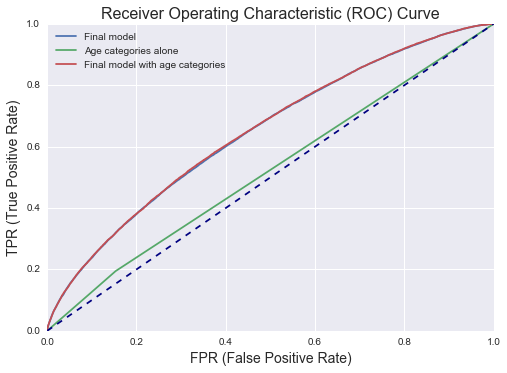

In [60]:
BoolAge = reduced_data[['BoolYoungLoanee','BoolOldLoanee']]
X_age = pd.concat([X_final,BoolAge], axis=1)

fig, ax = plt.subplots()

## scale the variables first
standard_scaler = preprocessing.StandardScaler()
X_age_sc = standard_scaler.fit_transform(X_age)

for X in [X_final_sc, BoolAge, X_age_sc]:
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=0)
    logm = linear_model.LogisticRegression()
    logm.fit(X_tr,y_tr)
    probs = logm.predict_proba(X_te)
    fpr, tpr, thresholds = metrics.roc_curve(y_te,probs[:,1])
    plt.plot(fpr,tpr)
    print(logm.coef_)
    
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize = 16)
plt.xlabel('FPR (False Positive Rate)', fontsize=14)
plt.ylabel('TPR (True Positive Rate)', fontsize=14)

handles, labels = ax.get_legend_handles_labels()
mylabels = ['Final model','Age categories alone','Final model with age categories']
legend = ax.legend(handles, labels = mylabels, loc = 2)

## draw the "no-skill" line
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

The improvement to the existing model is minor compared to the other variables we've explored, but still noticeable. Let's add BoolYoungLoanee and BoolOldLoanee to the final model.

In [61]:
X_final['BoolYoungLoanee'] = reduced_data['BoolYoungLoanee']
X_final['BoolOldLoanee'] = reduced_data['BoolOldLoanee']

## save the final set of variables to pickle file for easy reload.
X_final.to_pickle('theorem_reduced_finalmodel.pkl')

### NumPublicRecordsLast10Years and NumPublicRecords12
These two variables are tricky to deal with because most loanees have no public records (especially not in the last 12 months).

In [62]:
print(reduced_data['NumPublicRecordsLast10Years'].value_counts(normalize = True))
print(reduced_data['NumPublicRecords12'].value_counts(normalize = True))

0     0.756754
1     0.212640
2     0.021040
3     0.005422
4     0.002099
5     0.000860
6     0.000499
7     0.000265
8     0.000154
9     0.000091
11    0.000032
14    0.000020
10    0.000020
12    0.000020
21    0.000012
15    0.000012
13    0.000008
18    0.000008
38    0.000008
44    0.000004
16    0.000004
17    0.000004
19    0.000004
26    0.000004
28    0.000004
37    0.000004
42    0.000004
59    0.000004
Name: NumPublicRecordsLast10Years, dtype: float64
0    0.995992
1    0.003541
2    0.000364
3    0.000071
4    0.000028
6    0.000004
Name: NumPublicRecords12, dtype: float64


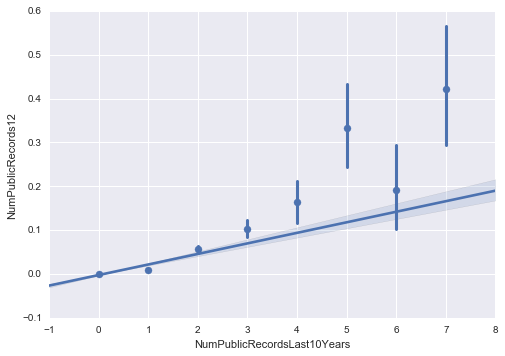

In [63]:
## unsurprisingly, there is a weak correlation between the number of public records in the last 12 months and in the last 10 years.
sns.regplot(reduced_data['NumPublicRecordsLast10Years'],reduced_data['NumPublicRecords12'],x_bins=2000)

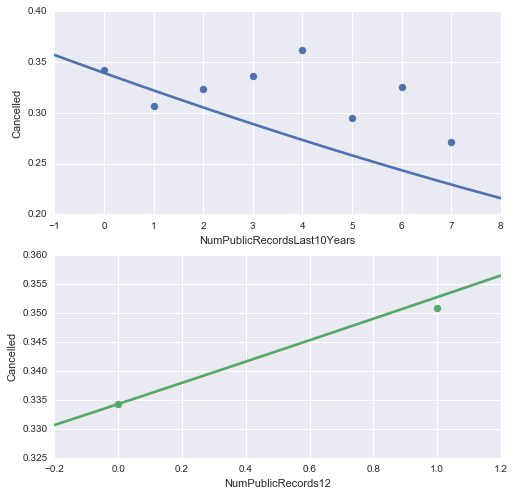

In [64]:
date_vars = reduced_data[['NumPublicRecordsLast10Years','NumPublicRecords12']]

## create one big figure behind subpanels
fig, axes = plt.subplots(2,1,figsize=(8,8), facecolor='w')

## cycle through each numeric variable and logistic regress with cancellation (excluding cancellation itself)
for ax, var in zip(axes.reshape(-1),date_vars.columns.values):
    sns.regplot(ax=ax, x=var, y="Cancelled", data=reduced_data, logistic=True, ci = None, x_bins = 2000)

In [65]:
print('Past 10 years:')
print('Non-zero public records', reduced_data[reduced_data['NumPublicRecordsLast10Years'] > 0]['Cancelled'].mean())
print('No public records', reduced_data[reduced_data['NumPublicRecordsLast10Years'] == 0]['Cancelled'].mean())

print('Past 12 months:')
print('Non-zero public records', reduced_data[reduced_data['NumPublicRecords12'] > 0]['Cancelled'].mean())
print('No public records', reduced_data[reduced_data['NumPublicRecords12'] == 0]['Cancelled'].mean())

Past 10 years:
Non-zero public records 0.309548622419
No public records 0.342342861031
Past 12 months:
Non-zero public records 0.350790513834
No public records 0.334299701341


NumPublicRecords12 looks useless for our purposes. Meanwhile, the fit for NumPublicRecordsLast10Years is lackluster for high numbers of records, but just looking at whether they have any records or not seems potentially promising.

In [66]:
reduced_data['BoolNonzeroPublicRecordsLast10Years'] = reduced_data['NumPublicRecordsLast10Years'] > 0

In [67]:
X_records = pd.concat([X_final,reduced_data['BoolNonzeroPublicRecordsLast10Years']], axis=1)
X_records.head()

,BoolPriorProsperLoanee,DolLoanAmountRequested,PctBankcardUtil,StrEmploymentStatus_Employed,StrEmploymentStatus_Full-time,StrEmploymentStatus_Other,StrEmploymentStatus_Self-employed,DolMonthlyDebt,DolMonthlyIncome,BorrowerRate,NumRealEstateTrades,StrOccupation_Accountant/CPA,StrOccupation_Administrative Assistant,StrOccupation_Analyst,StrOccupation_Architect,StrOccupation_Attorney,StrOccupation_Biologist,StrOccupation_Bus Driver,StrOccupation_Car Dealer,StrOccupation_Chemist,StrOccupation_Civil Service,StrOccupation_Clergy,StrOccupation_Clerical,StrOccupation_Computer Programmer,StrOccupation_Construction,StrOccupation_Dentist,StrOccupation_Doctor,StrOccupation_Engineer - Chemical,StrOccupation_Engineer - Electrical,StrOccupation_Engineer - Mechanical,StrOccupation_Executive,StrOccupation_Fireman,StrOccupation_Flight Attendant,StrOccupation_Food Service,StrOccupation_Food Service Management,StrOccupation_Homemaker,StrOccupation_Investor,StrOccupation_Judge,StrOccupation_Laborer,StrOccupation_Landscaping,StrOccupation_Medical Technician,StrOccupation_Military Enlisted,StrOccupation_Military Officer,StrOccupation_Nurse (LPN),StrOccupation_Nurse (RN),StrOccupation_Nurse's Aide,StrOccupation_Other,StrOccupation_Pharmacist,StrOccupation_Pilot - Private/Commercial,StrOccupation_Police Officer/Correction Officer,StrOccupation_Postal Service,StrOccupation_Principal,StrOccupation_Professional,StrOccupation_Professor,StrOccupation_Psychologist,StrOccupation_Realtor,StrOccupation_Religious,StrOccupation_Retail Management,StrOccupation_Sales - Commission,StrOccupation_Sales - Retail,StrOccupation_Scientist,StrOccupation_Skilled Labor,StrOccupation_Social Worker,StrOccupation_Student - College Freshman,StrOccupation_Student - College Graduate Student,StrOccupation_Student - College Junior,StrOccupation_Student - College Senior,StrOccupation_Student - College Sophomore,StrOccupation_Student - Community College,StrOccupation_Student - Technical School,StrOccupation_Teacher,StrOccupation_Teacher's Aide,StrOccupation_Tradesman - Carpenter,StrOccupation_Tradesman - Electrician,StrOccupation_Tradesman - Mechanic,StrOccupation_Tradesman - Plumber,StrOccupation_Truck Driver,StrOccupation_Waiter/Waitress,BoolYoungLoanee,BoolOldLoanee,BoolNonzeroPublicRecordsLast10Years
ListingNumber,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
973605,False,15000.0,0.97,1,0,0,0,1242,6000.0000,0.1620,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,False,True,False
981099,False,15000.0,0.48,0,0,1,0,2289,7916.6667,0.1585,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,True,False
1025766,True,4000.0,0.93,1,0,0,0,911,2083.3333,0.2085,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,False
1003835,False,10000.0,0.26,1,0,0,0,223,3750.0000,0.1299,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,False,False
1011335,True,20000.0,0.81,1,0,0,0,1264,9000.0000,0.1440,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,True


(252469, 81)
(252469, 80)
[[ -2.70323463e-01   2.52892393e-01  -1.44329362e-01   5.23994175e-02
   -8.13246034e-03   6.92331194e-02  -1.50999440e-01  -1.20250351e-01
    4.40651717e-01   6.75626357e-02  -8.05918810e-02  -1.22701022e-01
   -8.91444481e-02  -1.84887970e-01  -3.52269067e-02  -5.21727618e-02
   -1.80168620e-02  -1.08753067e-02  -2.25082020e-02  -2.73220056e-02
   -1.13536935e-01  -1.63144275e-03  -1.03589953e-01  -1.90915239e-01
   -4.11345259e-02   7.65999488e-03  -2.49071115e-02  -2.78077476e-02
   -9.33481375e-02  -9.60818739e-02  -1.33211913e-01  -4.80195613e-02
   -1.08368764e-02  -2.44039257e-03  -3.54439698e-02   2.73632912e-02
    5.26998804e-03  -8.73582832e-03  -2.93163134e-02   3.06637311e-03
   -5.34245605e-02  -7.43238968e-02  -4.90946570e-02  -2.85733304e-02
   -1.44356365e-01  -1.74883856e-03  -3.12617278e-01  -4.39336609e-02
   -2.76819576e-02  -1.14101368e-01  -6.48035317e-02  -3.91272737e-02
   -2.66155144e-01  -6.72777188e-02  -1.84637873e-02   1.4078010

//anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:492: UserWarning: You have mixed positional and keyword arguments, some input will be discarded.
  warnings.warn("You have mixed positional and keyword "


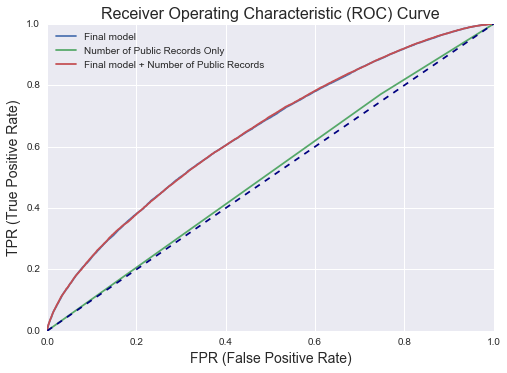

In [68]:
X_records = pd.concat([X_final,reduced_data['BoolNonzeroPublicRecordsLast10Years']], axis=1)
print(X_records.shape)

fig, ax = plt.subplots()

## scale the variables first
ss1 = preprocessing.StandardScaler()
X_final_sc = ss1.fit_transform(X_final)

ss2 = preprocessing.StandardScaler()
X_records_sc = ss2.fit_transform(X_records)

for X in [X_final_sc, reduced_data['BoolNonzeroPublicRecordsLast10Years'].to_frame(), X_records_sc]:
    print(X.shape)
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=0)
    logm = linear_model.LogisticRegression()
    logm.fit(X_tr,y_tr)
    probs = logm.predict_proba(X_te)
    fpr, tpr, thresholds = metrics.roc_curve(y_te,probs[:,1])
    plt.plot(fpr,tpr)
    print(logm.coef_)
    
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize = 16)
plt.xlabel('FPR (False Positive Rate)', fontsize=14)
plt.ylabel('TPR (True Positive Rate)', fontsize=14)

handles, labels = ax.get_legend_handles_labels()
mylabels = ['Final model','Number of Public Records Only','Final model + Number of Public Records']
legend = ax.legend(handles, labels = mylabels, loc = 2)

## draw the "no-skill" line
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

Again, the benefits of including the number of previous public records are marginal, but including it as a variable does improve predictive skill - let's add the new variable BoolNonzeroPublicRecordsLast10Years to the final model.

In [69]:
X_final['BoolNonzeroPublicRecordsLast10Years'] = reduced_data['BoolNonzeroPublicRecordsLast10Years']

## save the final set of variables to pickle file for easy reload.
X_final.to_pickle('theorem_reduced_finalmodel.pkl')

## Discarded Variables

### Trades

In [70]:
print(reduced_data['NumTradesOpened6'].value_counts(normalize = True))
print(reduced_data['NumOpenTradesDelinqOrPastDue6'].value_counts(normalize = True))

0     0.440430
1     0.309709
2     0.149999
3     0.062233
4     0.023013
5     0.009007
6     0.003355
7     0.001351
8     0.000503
9     0.000238
10    0.000067
12    0.000036
13    0.000028
11    0.000024
37    0.000004
14    0.000004
Name: NumTradesOpened6, dtype: float64
0    0.994340
1    0.005418
2    0.000210
3    0.000024
4    0.000008
Name: NumOpenTradesDelinqOrPastDue6, dtype: float64


In [71]:
print('Trades opened in last 6 months:')
print('Non-zero:', reduced_data[reduced_data['NumTradesOpened6'] > 0]['Cancelled'].mean())
print('Zero:', reduced_data[reduced_data['NumTradesOpened6'] == 0]['Cancelled'].mean())

print('Number of delinquent trades in last 6 months:')
print('Non-zero:', reduced_data[reduced_data['NumOpenTradesDelinqOrPastDue6'] > 0]['Cancelled'].mean())
print('Zero:', reduced_data[reduced_data['NumOpenTradesDelinqOrPastDue6'] == 0]['Cancelled'].mean())

Trades opened in last 6 months:
Non-zero: 0.336190664949
Zero: 0.332047304285
Number of delinquent trades in last 6 months:
Non-zero: 0.375787263821
Zero: 0.33413001912


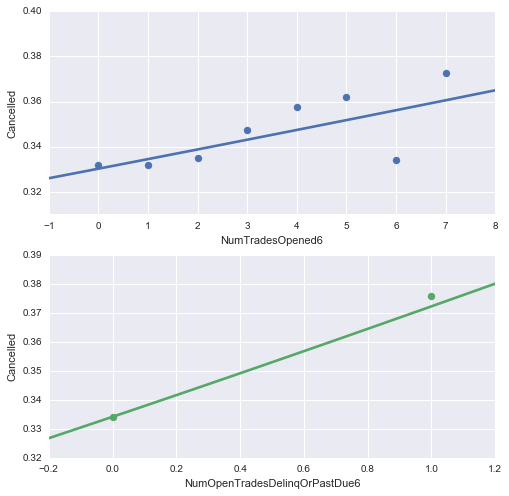

In [72]:
date_vars = reduced_data[['NumTradesOpened6','NumOpenTradesDelinqOrPastDue6']]

## create one big figure behind subpanels
fig, axes = plt.subplots(2,1,figsize=(8,8), facecolor='w')

## cycle through each numeric variable and logistic regress with cancellation (excluding cancellation itself)
for ax, var in zip(axes.reshape(-1),date_vars.columns.values):
    sns.regplot(ax=ax, x=var, y="Cancelled", data=reduced_data, logistic=True, ci = None, x_bins = 1000)

The effects are pretty minimal, and in the case of NumOpenTradesDelinqOrPastDue6 only a very small percentage of population nonzero. As shown below, including them doesn't affect the model at all, so we discard them.

//anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


[[ -2.68658012e-01   2.45275853e-01  -1.43273054e-01   5.23819635e-02
   -8.18934031e-03   7.06578144e-02  -1.52543065e-01  -1.34856939e-01
    4.55983847e-01   7.94571369e-02  -7.80896801e-02  -1.22911674e-01
   -8.87068901e-02  -1.85513329e-01  -3.54270677e-02  -5.23863095e-02
   -1.85061716e-02  -9.38708650e-03  -2.17686672e-02  -2.77573542e-02
   -1.13520387e-01  -2.01154206e-03  -1.02907336e-01  -1.91674914e-01
   -4.04923331e-02   7.89383627e-03  -2.46707879e-02  -2.83672523e-02
   -9.36806984e-02  -9.62098203e-02  -1.32366726e-01  -4.82841968e-02
   -1.07280112e-02  -2.77471684e-03  -3.55049373e-02   2.71805901e-02
    4.75477161e-03  -8.90651978e-03  -2.87303381e-02   3.09462997e-03
   -5.34062891e-02  -7.57201372e-02  -4.96549293e-02  -2.83963776e-02
   -1.44857916e-01  -1.84636705e-03  -3.12522483e-01  -4.42163095e-02
   -2.75884025e-02  -1.13917533e-01  -6.47135145e-02  -3.93850188e-02
   -2.65374377e-01  -6.76957363e-02  -1.83400255e-02   1.54919599e-02
    1.22993215e-02  

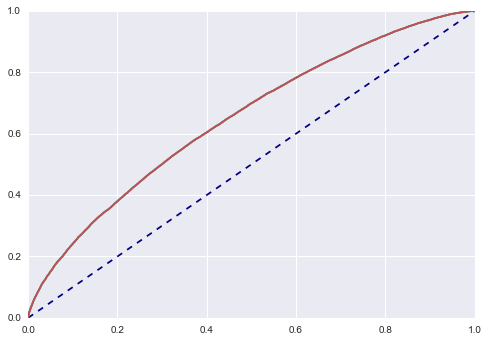

In [73]:
variables = [[],['NumTradesOpened6'],['NumOpenTradesDelinqOrPastDue6']]

X_s = []
X_train = []
X_test = []
y_train = []
y_test = []

fig, ax = plt.subplots()
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

for i,v in enumerate(variables):
    
    X = pd.concat([X_final,reduced_data[v]], axis=1)
    standard_scaler = preprocessing.StandardScaler()
    X_s.append(standard_scaler.fit_transform(X))
    X_tr, X_te, y_tr, y_te = train_test_split(X_s[i], y, test_size=0.3, random_state=0)
    logm = linear_model.LogisticRegression()
    logm.fit(X_tr,y_tr)
    probs = logm.predict_proba(X_te)
    #print(probs[:20])
    fpr, tpr, thresholds = metrics.roc_curve(y_te,probs[:,1])
    plt.plot(fpr,tpr)
    plt.legend()
    print(logm.coef_)

### Variables with NaNs
I put off dealing with NumPriorProsperLoansLatePayments and NumPriorProsperLoans61dpd until now because they contain large amount of NaNs. Misleadingly, they also have cancellation rates that are significantly different from the mean - but that's because the only non-NaN values are among people who've taken out Prosper loans before, and we already know that those people are much less likely to cancel.

In [74]:
print(reduced_data['NumPriorProsperLoansLatePayments'].isnull().value_counts())
print(reduced_data['NumPriorProsperLoans61dpd'].isnull().value_counts())

print(reduced_data['NumPriorProsperLoansLatePayments'].value_counts())
print(reduced_data['NumPriorProsperLoans61dpd'].value_counts())

True     236180
False     16289
Name: NumPriorProsperLoansLatePayments, dtype: int64
True     252419
False        50
Name: NumPriorProsperLoans61dpd, dtype: int64
0.0     16138
1.0        68
2.0        25
3.0        13
4.0        10
5.0         6
7.0         6
6.0         6
9.0         6
13.0        3
8.0         3
25.0        2
10.0        2
11.0        1
Name: NumPriorProsperLoansLatePayments, dtype: int64
1.0    47
2.0     3
Name: NumPriorProsperLoans61dpd, dtype: int64


Only 50 people have non-NaN values of NumPriorProsperLoans61dpd! It would be more useful if we swapped in 0s for prior loanees who haven't had a loan go 61 days past due.

In [75]:
index = (reduced_data['BoolPriorProsperLoanee'] == True) & reduced_data['NumPriorProsperLoans61dpd'].isnull()
reduced_data['NumPriorProsperLoans61dpd'][index] = 0

## let's make sure that this worked out the way we intended it to...
reduced_data[:20]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,DolLoanAmountRequested,BorrowerRate,NumMonthsTerm,EnumListingCategory,DolMonthlyIncome,FracDebtToIncomeRatio,StrEmploymentStatus,StrOccupation,NumMonthsEmployed,NumPriorProsperLoansLatePayments,NumPriorProsperLoans61dpd,BoolIsLender,BoolInGroup,EnumChannelCode,NumTradesOpened6,NumOpenTradesDelinqOrPastDue6,DolTotalBalanceOnPublicRecords,NumRealEstateTrades,DolMonthlyDebt,NumCurrentDelinquencies,NumPublicRecordsLast10Years,NumPublicRecords12,DolAmountDelinquent,PctBankcardUtil,NumTotalInquiries,DaysSinceFirstCredit,Cancelled,BoolPriorProsperLoanee,BoolYoungLoanee,BoolOldLoanee,BoolNonzeroPublicRecordsLast10Years
ListingNumber,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
973605,15000.0,0.1620,60,1,6000.0000,0.27,Employed,Tradesman - Mechanic,445.0,NaN,NaN,0,False,70000,1,0,0,2,1242,0,0,0,0,0.97,5,13920,1,False,False,True,False
981099,15000.0,0.1585,60,1,7916.6667,0.35,Other,NaN,32.0,NaN,NaN,0,False,70000,1,0,0,2,2289,0,0,0,0,0.48,3,14257,1,False,False,True,False
1025766,4000.0,0.2085,36,1,2083.3333,0.53,Employed,Professional,4.0,0.0,0.0,0,False,80000,0,0,0,0,911,0,0,0,0,0.93,5,4165,0,True,False,False,False
1003835,10000.0,0.1299,36,13,3750.0000,0.14,Employed,Medical Technician,2.0,NaN,NaN,0,False,90000,1,0,0,0,223,0,0,0,0,0.26,1,2961,1,False,True,False,False
1011335,20000.0,0.1440,60,1,9000.0000,0.16,Employed,Executive,90.0,0.0,0.0,0,False,80000,1,0,1249,1,1264,1,2,0,0,0.81,17,8348,0,True,False,False,True
1010105,10000.0,0.2225,36,1,8416.6667,0.45,Employed,Professional,125.0,NaN,NaN,0,False,90000,0,0,0,2,3455,0,0,0,0,0.87,8,11061,0,False,False,False,False
1029573,15000.0,0.0809,36,3,6250.0000,NaN,Self-employed,Food Service,9.0,0.0,0.0,1,False,80000,1,0,0,2,1488,0,1,0,0,0.00,8,11029,0,True,False,False,True
1014296,7000.0,0.0769,36,3,3333.3333,0.16,Employed,Retail Management,22.0,NaN,NaN,0,False,40000,0,0,0,0,308,0,0,0,0,0.05,1,3899,0,False,True,False,False
1009580,5000.0,0.1314,36,1,6450.9167,0.15,Employed,Other,268.0,NaN,NaN,0,False,90000,2,0,0,3,846,0,1,0,0,0.82,8,9566,0,False,False,False,True


In [76]:
print('Number of Prior Prosper Loan Late Payments:')
print('Non-zero:', reduced_data[reduced_data['NumPriorProsperLoansLatePayments'] > 0]['Cancelled'].mean())
print('Zero:', reduced_data[reduced_data['NumPriorProsperLoansLatePayments'] == 0]['Cancelled'].mean())

print('Number of prior prosper loans more than 61 days past due:')
print('Non-zero:', reduced_data[reduced_data['NumPriorProsperLoans61dpd'] > 0]['Cancelled'].mean())
print('Zero:', reduced_data[reduced_data['NumPriorProsperLoans61dpd'] == 0]['Cancelled'].mean())

Number of Prior Prosper Loan Late Payments:
Non-zero: 0.165562913907
Zero: 0.133349857479
Number of prior prosper loans more than 61 days past due:
Non-zero: 0.22
Zero: 0.133374384236


These aren't huge differences, but let's try looking just among prior Prosper loanees and see if either of these variables can help make projections amongst them.

In [77]:
## I have to append the cancellation vector to the X matrix so I can drop the correct rows (leaving only rows with)
## prior prosper loanees
X_final['NumPriorProsperLoansLatePayments'] = reduced_data['NumPriorProsperLoansLatePayments']
X_final['NumPriorProsperLoans61dpd'] = reduced_data['NumPriorProsperLoans61dpd']
X_final['Cancelled'] = reduced_data['Cancelled']

In [78]:
data_nan = X_final.dropna()
print(data_nan.shape)

X_final.drop('NumPriorProsperLoansLatePayments',inplace=True,axis=1)
X_final.drop('NumPriorProsperLoans61dpd',inplace=True,axis=1)
X_final.drop('Cancelled',inplace=True,axis=1)


(16289, 84)


[[ 0.03231427]]
[[ 0.05239108]]


//anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


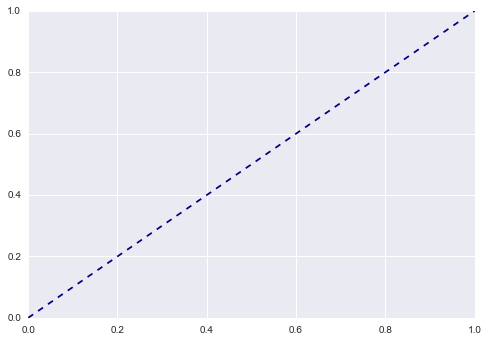

In [82]:
variables = [['NumPriorProsperLoansLatePayments'],['NumPriorProsperLoans61dpd']]

y = data_nan['Cancelled']
X = []
X_train = []
X_test = []
y_train = []
y_test = []

fig, ax = plt.subplots()
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

for i,v in enumerate(variables):
    standard_scaler = preprocessing.StandardScaler()
    X.append(standard_scaler.fit_transform(data_nan[v]))
    X_tr, X_te, y_tr, y_te = train_test_split(X[i], y, test_size=0.3, random_state=0)
    logm = linear_model.LogisticRegression()
    logm.fit(X_tr,y_tr)
    probs = logm.predict_proba(X_te)
    #print(probs[:20])
    fpr, tpr, thresholds = metrics.roc_curve(y_te,probs[:,1])
    plt.legend()
    print(logm.coef_)

Even looking just among the population of prior Prosper loanees, NumPriorProsperLoansLatePayments and NumPriorProsperLoans61dpd have essentially no predictive skill, so we can simply leave them out of the broader model.

### Leftover variables
Here I show that all of the remaining variables have minimal effect on cancellation.

In [83]:
print(reduced_data[reduced_data['DolAmountDelinquent']!=0]['Cancelled'].mean())
print(reduced_data[reduced_data['DolAmountDelinquent']==0]['Cancelled'].mean())

0.342281440841
0.333273232123


In [84]:
print(reduced_data[reduced_data['DolTotalBalanceOnPublicRecords']!=0]['Cancelled'].mean())
print(reduced_data[reduced_data['DolTotalBalanceOnPublicRecords']==0]['Cancelled'].mean())

0.34695719443
0.333966728372


In [85]:
print(reduced_data[reduced_data['NumCurrentDelinquencies']!=0]['Cancelled'].mean())
print(reduced_data[reduced_data['NumCurrentDelinquencies']==0]['Cancelled'].mean())

0.334405972455
0.334358499045


In [86]:
print(reduced_data[reduced_data['NumMonthsTerm']==36]['Cancelled'].mean())
print(reduced_data[reduced_data['NumMonthsTerm']==60]['Cancelled'].mean())

0.329599687746
0.34403185569


As also indicated by the regression, DolAmountDelinquent, DolTotalBalanceOnPublicRecords, NumCurrentDelinquencies and NumMonthsTerm do not show a strong difference between behavior of zero and non-zero loanees, and are omitted from model (to make 100% sure, notebook scratch_3 shows what happens when they're added to the model).

## Evaluating final model performance

In [87]:
X_final.columns

Index(['BoolPriorProsperLoanee', 'DolLoanAmountRequested', 'PctBankcardUtil',
       'StrEmploymentStatus_Employed', 'StrEmploymentStatus_Full-time',
       'StrEmploymentStatus_Other', 'StrEmploymentStatus_Self-employed',
       'DolMonthlyDebt', 'DolMonthlyIncome', 'BorrowerRate',
       'NumRealEstateTrades', 'StrOccupation_Accountant/CPA',
       'StrOccupation_Administrative Assistant', 'StrOccupation_Analyst',
       'StrOccupation_Architect', 'StrOccupation_Attorney',
       'StrOccupation_Biologist', 'StrOccupation_Bus Driver',
       'StrOccupation_Car Dealer', 'StrOccupation_Chemist',
       'StrOccupation_Civil Service', 'StrOccupation_Clergy',
       'StrOccupation_Clerical', 'StrOccupation_Computer Programmer',
       'StrOccupation_Construction', 'StrOccupation_Dentist',
       'StrOccupation_Doctor', 'StrOccupation_Engineer - Chemical',
       'StrOccupation_Engineer - Electrical',
       'StrOccupation_Engineer - Mechanical', 'StrOccupation_Executive',
       'StrOccupa

[[ -2.68658012e-01   2.45275853e-01  -1.43273054e-01   5.23819635e-02
   -8.18934031e-03   7.06578144e-02  -1.52543065e-01  -1.34856939e-01
    4.55983847e-01   7.94571369e-02  -7.80896801e-02  -1.22911674e-01
   -8.87068901e-02  -1.85513329e-01  -3.54270677e-02  -5.23863095e-02
   -1.85061716e-02  -9.38708650e-03  -2.17686672e-02  -2.77573542e-02
   -1.13520387e-01  -2.01154206e-03  -1.02907336e-01  -1.91674914e-01
   -4.04923331e-02   7.89383627e-03  -2.46707879e-02  -2.83672523e-02
   -9.36806984e-02  -9.62098203e-02  -1.32366726e-01  -4.82841968e-02
   -1.07280112e-02  -2.77471684e-03  -3.55049373e-02   2.71805901e-02
    4.75477161e-03  -8.90651978e-03  -2.87303381e-02   3.09462997e-03
   -5.34062891e-02  -7.57201372e-02  -4.96549293e-02  -2.83963776e-02
   -1.44857916e-01  -1.84636705e-03  -3.12522483e-01  -4.42163095e-02
   -2.75884025e-02  -1.13917533e-01  -6.47135145e-02  -3.93850188e-02
   -2.65374377e-01  -6.76957363e-02  -1.83400255e-02   1.54919599e-02
    1.22993215e-02  

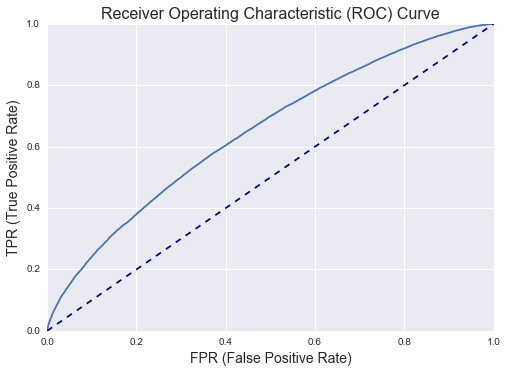

In [88]:
fig, ax = plt.subplots()

## scale the variables first
ss = preprocessing.StandardScaler()
X_final_sc = ss.fit_transform(X_final)

y = reduced_data['Cancelled']

X_tr, X_te, y_tr, y_te = train_test_split(X_final_sc, y, test_size=0.3, random_state=0)
logm = linear_model.LogisticRegression()
logm.fit(X_tr,y_tr)
probs = logm.predict_proba(X_te)
fpr, tpr, thresholds = metrics.roc_curve(y_te,probs[:,1])
score = metrics.roc_auc_score(y_te, probs[:,1])
plt.plot(fpr,tpr)
print(logm.coef_)
print("AUC score:",score)
    
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize = 16)
plt.xlabel('FPR (False Positive Rate)', fontsize=14)
plt.ylabel('TPR (True Positive Rate)', fontsize=14)

## draw the "no-skill" line
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.savefig('roc_final.jpg')

# Final thoughts and caveats

Some of the variables in this study are treated as linear in this model, but clearly merit further investigation. For instance, the distribution of cancellation rates depending on BorrowerRate clearly looks parabolic, with lower cancellation probability at both low and high rates. Similarly, younger and older borrowers appear much more likely to cancel than middle-aged borrowers. However, for a first pass at a model I have decided not to include non-linear term to avoid over-complexification.

It is possible that some model variables that were omitted early on are actual crucial to predictivity. For instance, I chose to leave out the state of the loanee, because I felt that geographic effects on cancellation ought to be secondary relative to economic effects. However, I eventually decided to include the type of employment even without a causal mechanism for why different job types might lead to different cancellation rates.